In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/CIS 581 - Computer Vision and Computational Photography/Project 4 - Homography Estimation

/content/drive/My Drive/CIS 581 - Computer Vision and Computational Photography/Project 4 - Homography Estimation


In [34]:
'''
import library 
'''
!pip install -U opencv-contrib-python==3.4.0.12
import numpy as np
import cv2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

Requirement already up-to-date: opencv-contrib-python==3.4.0.12 in /usr/local/lib/python3.6/dist-packages (3.4.0.12)


In [47]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
  """
  compute the homography transform
  p1, p2: 4 x 2, 4 groups of corresponding points
  """	
  # IMPLEMENT HERE, hint: you may find np.linalg.svd useful

  # construct the A matrix in the same way in the slides
  A = np.array([[p2[0,0], p2[0,1], 1, 0, 0, 0, -1*p2[0,0]*p1[0,0], -1*p2[0,1]*p1[0,0], -1*p1[0,0]],
               [0,0,0, p2[0,0], p2[0,1], 1, -1*p2[0,0]*p1[0,1], -1*p2[0,1]*p1[0,1], -1*p1[0,1]],
                [p2[1,0], p2[1,1], 1, 0, 0, 0, -1*p2[1,0]*p1[1,0], -1*p2[1,1]*p1[1,0], -1*p1[1,0]], 
                [0,0,0, p2[1,0], p2[1,1], 1, -1*p2[1,0]*p1[1,1], -1*p2[1,1]*p1[1,1], -1*p1[1,1]],
                [p2[2,0], p2[2,1], 1, 0, 0, 0, -1*p2[2,0]*p1[2,0], -1*p2[2,1]*p1[2,0], -1*p1[2,0]], 
                [0,0,0, p2[2,0], p2[2,1], 1, -1*p2[2,0]*p1[2,1], -1*p2[2,1]*p1[2,1], -1*p1[2,1]],
                [p2[3,0], p2[3,1], 1, 0, 0, 0, -1*p2[3,0]*p1[3,0], -1*p2[3,1]*p1[3,0], -1*p1[3,0]], 
                [0,0,0, p2[3,0], p2[3,1], 1, -1*p2[3,0]*p1[3,1], -1*p2[3,1]*p1[3,1], -1*p1[3,1]]])
  # use SVD to find the solution to Ax = 0
  u, s, vh = np.linalg.svd(A)
  v = vh.T
  h = v[:,-1]/v[-1,-1]
  H = h.reshape(3,3)
  # reorgnize the solution vector and normalize it to get homography matrix
  return H

In [48]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ [115.0000,  120.0000],
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)
assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [77]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [50]:
def nearestNeighborWithRatioTest(distanceMatrix, axis = -1, allowableRatio = 0.7):
  """
  This method will determine the nearest neighbor to each feature by sorting the distance matrix along the axis of choice and then checking if the ratio between closest and second closest neighbor is below the allowable ratio indicated
  If so, it will return a np.array of nearest neighbors that have passed the ratio test
  distanceMatrix: 2 dimensional matrix that has the elements in rows that need to be sorted with a nearest neighbor search
  axis: The axis to sort about and return a value. Default is the last axis
  return: a numpy array of a list of nearest neighbors that pass the ratio test
  """

  #error check to see if distanceMatrix is a numpy array
  if type(distanceMatrix) is not np.ndarray:
    raise ValueError("distanceMatrix must be a 2-dimensional numpy array")
  #error check to see if the distance matrix is not a 2D array
  if len(distanceMatrix.shape) != 2:
    raise ValueError('distanceMatrix must be a 2-dimensional array.')

  if axis < -2 or axis > 1:
    raise ValueError('Please input an axis value between -2 and 1. 2D numpy arrays only allow for these axes')

  match = []
  sortedRowsIndices = np.argsort(distanceMatrix, axis) #sort the indices of all the rows
  distanceMatrixSortedRows = np.sort(distanceMatrix, axis) #actually sort the matrices
  if axis == 0 or axis == -2:
    nearestNeighborRatioTest = distanceMatrixSortedRows[0,:]/distanceMatrixSortedRows[1,:] < allowableRatio #divide the first column in the sorted row by the second column in the sorted row and check if it meets the allowableRatio threshold
  else:
    nearestNeighborRatioTest = distanceMatrixSortedRows[:,0]/distanceMatrixSortedRows[:,1] < allowableRatio #divide the first column in the sorted row by the second column in the sorted row and check if it meets the allowableRatio threshold
  

  #for each item in the nearest neighbor search, check if the ratio test passed. If so then add it to the list of matches
  for i in range(0, len(nearestNeighborRatioTest)):
    if nearestNeighborRatioTest[i]:
      if axis == 0 or axis == -2:
        match.append([sortedRowsIndices[0, i], i])
      else:
        match.append([i, sortedRowsIndices[i, 0]])
  match = np.array(match) #convert the list to a numpy array

  return match



In [79]:
'''
Function (modify)
'''
def match_features(f1,f2):
  """
  f1, f2: N * feature_size, two features to be matched
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful
  N = f1.shape[0]
  M = f2.shape[0]
  # compute pairwise distance between f1 and f2
  distanceMatrix = cdist(f1, f2)
  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  match_fwd = nearestNeighborWithRatioTest(distanceMatrix, 1)
  
  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  match_bkwd = nearestNeighborWithRatioTest(distanceMatrix, 0)


  # get the intersect of two matching as the final result with python set 
  set1 = set(map(tuple, match_fwd)) #convert numpy array to Python set
  set2 = set(map(tuple, match_bkwd)) #convert numpy array to Python set
  intersect = set1 & set2 #intersect the two sets
  match = np.array(list(intersect)) #convert the set back to numpy array
  return match, match_fwd, match_bkwd

In [52]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

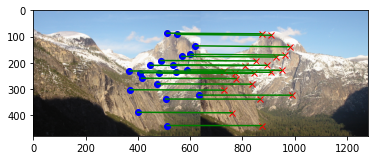

In [80]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [81]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
  """
  p1, p2: N * 2, correponding point coordinates
  """
  # IMPLEMENT HERE
  
  # decide how many loops to run and what the threshold is
  n = 4 # number of points required to develop a homography model
  w = 0.5 # probability of choosing an inlier = (number of inliers) / (number of samples)
  p = 1 - 1e-4 # desired RANSAC success rate
  k = np.log(1-p) / np.log(1 - np.power(w, n)) #Required number of iterations with p success rate

  threshold = np.sqrt(2) #threshold for error away from model
  best_H = [] #initialize best homography matrix
  nBest = 0 #initialize max number of inliears found

  # RANSAC loop, inside in the loop
  for i in range(0, int(k)):
    #     1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
    varTest = np.random.choice(p1.shape[0], n, replace = False) #randomly pick a set of indices from the input
    p1Rand = p1[varTest] #extract those indices from p1
    p2Rand = p2[varTest] #extract those indices from p2

    #     2. fit the model and get a estimation
    H = compute_homography(p1Rand, p2Rand) #compute the homography matrix from that randomly chosen sample. This is the model
    p2_Stacked = np.hstack((p2, np.ones((p2.shape[0], 1)))).T #input has an Nx2 dimension, need to add a row of 1s to get the required input and then transpose/stack it
    p2_Homogenous = H @ p2_Stacked #get the homogenous image after multipliying the stacked image by the Homography matrix
    p2_Homogenous = p2_Homogenous / p2_Homogenous[-1, :] #normalize values by dividing all values by the respective values in the third row (lambda factor scaling)
    p2_Homogenous = p2_Homogenous[:2] # get rid of last row of ones
    p2_Homogenous = p2_Homogenous.T #transform it back to initial shape
    distance = np.sqrt(np.power(p1[:,0] - p2_Homogenous[:,0], 2) + np.power(p1[:,1] - p2_Homogenous[:,1], 2)) #Calculate distance using square root sum of squares

    #     3. count consensus(# of inliners that is close to the estimatiion within the threshold)
    numInlier = np.count_nonzero(distance <= threshold) #find values where the distance is less than the threshold and count how many exist

    #     4. update the best estimation if the current one is better 
    if (numInlier > nBest): #if number of inliears in this iteration is larger than in previous iterations then update maximum values
      nBest = numInlier
      best_H = H
  
  return best_H

In [83]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
val =  ransac_homography(p1, p2)
assert np.allclose(H,val)

In [84]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    eps = 1e-7
    sy1, sx1, sz1 = I1.shape
    sy2, sx2, sz2 = I2.shape
    x2, y2 = np.meshgrid(np.arange(sx2), np.arange(sy2))
    # map I2 to I1
    p1_hat = H @ np.r_[x2.ravel(), y2.ravel(), np.ones_like(x2.ravel())].reshape(3, -1)
    p1_hat = p1_hat[0:2] / (p1_hat[2] + eps)

    # create new dimensions to accomodate points from I2
    p1_hat_xmax = np.max(p1_hat[0])
    p1_hat_xmin = np.min(p1_hat[0])
    p1_hat_ymax = np.max(p1_hat[1])
    p1_hat_ymin = np.min(p1_hat[1])

    xmin = np.rint(np.floor(np.minimum(p1_hat_xmin, 0))).astype(np.int32)
    xmax = np.rint(np.ceil(np.maximum(p1_hat_xmax, sx2))).astype(np.int32)
    ymin = np.rint(np.floor(np.minimum(p1_hat_ymin, 0))).astype(np.int32)
    ymax = np.rint(np.ceil(np.maximum(p1_hat_ymax, sy2))).astype(np.int32)

    # create images for mapping
    I1_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I2_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)

    # I1 is just translated in I_
    I1_[-ymin:sy1 - ymin, -xmin:sx1 - xmin, :] = I1[:min(sy1, ymax), :min(sx1, xmax), :]

    # map I_ to I2 (translation then homography)
    sy2_, sx2_, sz2_ = I2_.shape
    x2_, y2_ = np.meshgrid(np.arange(sx2_), np.arange(sy2_))
    p2_hat = np.linalg.inv(H) @ np.r_[x2_.ravel() + xmin, y2_.ravel() + ymin, np.ones(x2_.size)].reshape(3, -1)
    p2_hat = np.rint(p2_hat[0:2] / (p2_hat[2] + eps)).astype(np.int32)

    # keep only the valid coordinates of I2
    good_x = np.logical_and(p2_hat[0, :] >= 0, p2_hat[0, :] < sx2)
    good_y = np.logical_and(p2_hat[1, :] >= 0, p2_hat[1, :] < sy2)
    good = np.logical_and(good_x, good_y)


    # I2 transformed by homography in I_
    I2_[y2_[good.reshape(x2_.shape)], x2_[good.reshape(x2_.shape)]] = I2[p2_hat[1, good], p2_hat[0, good]]

    # nonoverlapping regions do not require blending
    I2_sum = np.sum(I2_, axis=2)
    I1_sum = np.sum(I1_, axis=2)

    # in no blend area, one of I1_ and I2_ is all 0 
    no_blend_area = np.logical_or(I2_sum == 0, I1_sum == 0)
    I_[no_blend_area] = I2_[no_blend_area] + I1_[no_blend_area]

    # in blend area, take the average of I1_ and I2_
    blend_area = np.logical_and(I2_sum > 0, I1_sum > 0)
    I_[blend_area] = (I1_[blend_area] * .5 + I2_[blend_area] * .5).astype(np.uint8)
    return I_

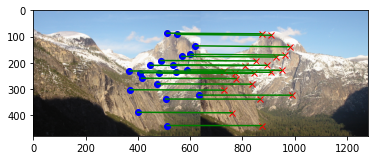

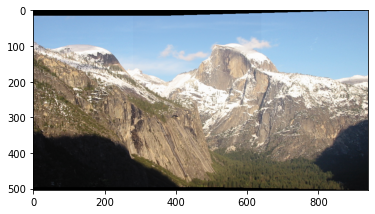

In [86]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.show()